In [1]:
# Set up the environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [2]:
# Upload the data
# data will contain everything, names and locations
# df will contain the features used in the modeling
data = pd.read_csv('data/processed/DecisionTreeData.csv', index_col=0)
data = data.loc[data.Year > 2009]
data.sort_index(inplace=True)
data.head()

,OPEID,INSTNM,CITY,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,region,ADM_RATE,UGDS,...,Year,NetPrice,Cost,EnrollmentBins,TuitionBins,ExpenditureBins,FacultyBins,Complete,RetentionFT,RetentionPT
47931,00100200,alabama a & m university,Normal,1,3,4,1.0,5.0,0.5129,4930.0,...,2010,8190.0,13762.0,xl,high,high,high,0.3306,0.7457,0.5000
47932,00105200,university of alabama at birmingham,Birmingham,1,3,4,1.0,5.0,0.8243,10661.0,...,2010,12838.0,18003.0,xl,high,highest,highest,0.4108,0.7997,0.7000
47933,02503400,amridge university,Montgomery,1,3,4,2.0,5.0,0.7143,370.0,...,2010,16546.0,20700.0,medium,highest,med,low,0.2308,0.8000,NaN
47934,00105500,university of alabama at huntsville,Huntsville,1,3,4,1.0,5.0,0.6614,5828.0,...,2010,7752.0,17064.0,xl,high,high,highest,0.4364,0.7545,0.5385
47935,00100500,alabama state university,Montgomery,1,3,4,1.0,5.0,0.4372,4882.0,...,2010,4061.0,14390.0,xl,high,high,high,0.2399,0.6352,0.4167


In [3]:
# Separate open and closed schoools
closed = data.loc[data.CURROPER == False]
closed.shape

(2759, 31)

In [4]:
open_df = data.loc[data.CURROPER==True]
open_df.shape

(27923, 31)

In [5]:
current = open_df.loc[data.Year > 2012]
current.shape

(7440, 31)

In [6]:
data = pd.concat([current, closed], axis = 0)
data.shape

(10199, 31)

In [7]:
#df contains just the feature to train the model on
to_drop = ['OPEID', 'INSTNM', 'CITY', 'HIGHDEG', 'ADM_RATE', 'NetPrice', 'region','EnrollmentBins',\
           'TuitionBins','ExpenditureBins','FacultyBins', 'AVGFACSAL', 'RetentionPT', 'PCTFLOAN', 'Year']
df = data.drop(to_drop, axis=1)
df.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,CURROPER,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,DEBT_MDN,Cost,Complete,RetentionFT
70813,1,3,1.0,4051.0,True,9063.0,7459.0,0.8856,0.1049,0.256983,0.228252,0.150838,19500.0,18888.0,0.2914,0.6314
70814,1,3,1.0,11200.0,True,9033.0,17208.0,0.9106,0.2422,0.445502,0.184674,0.113279,16250.0,19990.0,0.5377,0.8016
70815,1,3,2.0,322.0,True,12057.0,5123.0,0.6721,0.8540,0.288591,0.382550,0.041270,10500.0,12300.0,0.6667,0.3750
70816,1,3,1.0,5525.0,True,8322.0,9352.0,0.6555,0.2640,0.377617,0.149758,0.116747,16500.0,20306.0,0.4835,0.8098
70817,1,3,1.0,5354.0,True,7813.0,7393.0,0.6641,0.1270,0.183563,0.256749,0.109778,15854.5,17400.0,0.2517,0.6219


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10199 entries, 70813 to 78609
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NUMBRANCH          10199 non-null  int64  
 1   PREDDEG            10199 non-null  int64  
 2   CONTROL            10199 non-null  float64
 3   UGDS               10199 non-null  float64
 4   CURROPER           10199 non-null  bool   
 5   TUITFTE            10199 non-null  float64
 6   INEXPFTE           10199 non-null  float64
 7   PFTFAC             10199 non-null  float64
 8   UG25abv            10199 non-null  float64
 9   COMP_ORIG_YR4_RT   10199 non-null  float64
 10  WDRAW_ORIG_YR4_RT  10199 non-null  float64
 11  ENRL_ORIG_YR4_RT   10199 non-null  float64
 12  DEBT_MDN           10199 non-null  float64
 13  Cost               10199 non-null  float64
 14  Complete           10199 non-null  float64
 15  RetentionFT        10199 non-null  float64
dtypes: bool(1), float6

In [9]:
y = df.CURROPER
X = df.drop('CURROPER', axis=1)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)

In [11]:
X_test.shape

(3060, 15)

# Decision Tree Model
Basis for comparison

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

## Explore just the criterion and max_depth features

Code modified from https://towardsdatascience.com/decision-tree-build-prune-and-visualize-it-using-python-12ceee9af752

In [13]:
from sklearn import metrics
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1, 31):
    gtree = DecisionTreeClassifier(criterion='gini', max_depth=i, random_state=21)
    gtree.fit(X_train, y_train)
    gpredict = gtree.predict(X_test)
    acc_gini.append(metrics.accuracy_score(y_test, gpredict))
    ##
    etree = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=21)
    etree.fit(X_train, y_train)
    epredict = etree.predict(X_test)
    acc_entropy.append(metrics.accuracy_score(y_test, epredict))
    ##
    max_depth.append(i)

In [14]:
gini_max = max(acc_gini)
gini_idx = acc_gini.index(gini_max)
entropy_max = max(acc_entropy)
entropy_idx = acc_entropy.index(entropy_max)

if gini_max > entropy_max:
    depth = max_depth[gini_idx]
else:
    depth = max_depth[entropy_idx] 
    
print(depth)

14


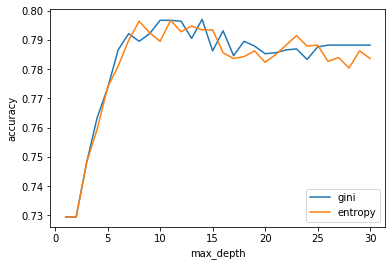

In [15]:
trees = pd.DataFrame({'acc_gini':pd.Series(acc_gini),
                     'acc_entropy':pd.Series(acc_entropy),
                     'max_depth':pd.Series(max_depth)})

plt.plot('max_depth', 'acc_gini', data=trees, label='gini')
plt.plot('max_depth', 'acc_entropy', data=trees, label='entropy')
#plt.vlines(6, 0.895, 0.915)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [16]:
# Train the decision tree using the identified hyperparameters
modelDT = DecisionTreeClassifier(criterion='gini', max_depth=depth, random_state=21)
modelDT.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=14, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=21, splitter='best')

In [17]:
# Use the trained tree to predict the testing data
dt_pred = modelDT.predict(X_test)
dt_pred_prob = modelDT.predict(X_test)

In [18]:
# Run this block for model evaluation 
#from sklearn import metrics
print("Model Metrics")
print("Accuracy:", metrics.accuracy_score(y_test, dt_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test, dt_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test, dt_pred, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_test, dt_pred, pos_label = 0))

Model Metrics
Accuracy: 0.7970588235294118
Balanced accuracy: 0.7465521271622253
Precision score for "Yes" 0.8639855399909625
Recall score for "No" 0.6364734299516909


In [19]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, dt_pred))

[[ 527  301]
 [ 320 1912]]


In [20]:
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

       False       0.62      0.64      0.63       828
        True       0.86      0.86      0.86      2232

    accuracy                           0.80      3060
   macro avg       0.74      0.75      0.74      3060
weighted avg       0.80      0.80      0.80      3060



In [21]:
importances = modelDT.feature_importances_
#std = np.std([tree.feature_importances_ for tree in modelDT.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, names[f], importances[indices[f]]))

Feature ranking:
1. feature CONTROL (0.126824)
2. feature UGDS (0.110463)
3. feature UG25abv (0.081431)
4. feature INEXPFTE (0.077269)
5. feature TUITFTE (0.076150)
6. feature Cost (0.074047)
7. feature DEBT_MDN (0.071240)
8. feature NUMBRANCH (0.066189)
9. feature WDRAW_ORIG_YR4_RT (0.058963)
10. feature COMP_ORIG_YR4_RT (0.058550)
11. feature Complete (0.047664)
12. feature ENRL_ORIG_YR4_RT (0.042732)
13. feature PREDDEG (0.042365)
14. feature RetentionFT (0.033883)
15. feature PFTFAC (0.032230)


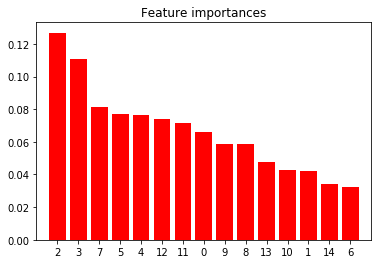

In [22]:
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", align="center") #yerr=std[indices]
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

CONTROL and UGDS are the most prominent features - that predict open schools. (Control is categorical, so I'm not exactly sure how to interpret it). More enrollment increases prediction of being open.

## AdaBoost model

In [23]:
ABmax_depth = []
score_a = []
score_b = []

for i in range(105, 131, 1):
    atree = AdaBoostClassifier(n_estimators=i, random_state=21)
    atree.fit(X_train, y_train)
    apredict = gtree.predict(X_test)
    score_a.append(metrics.accuracy_score(y_test, apredict))
    ##
    btree = AdaBoostClassifier(modelDT, n_estimators=i, random_state=21)
    btree.fit(X_train, y_train)
    bpredict = btree.predict(X_test)
    score_b.append(metrics.accuracy_score(y_test, bpredict))
    ##
    ABmax_depth.append(i)

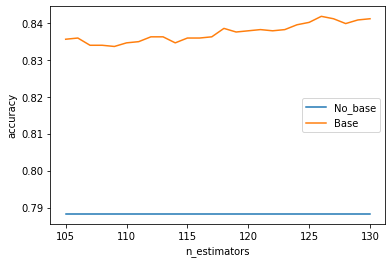

In [24]:
adatrees = pd.DataFrame({'score_a':pd.Series(score_a),
                     'score_b':pd.Series(score_b),
                     'n_estimators':pd.Series(ABmax_depth)})

plt.plot('n_estimators', 'score_a', data=adatrees, label='No_base')
plt.plot('n_estimators', 'score_b', data=adatrees, label='Base')
#plt.vlines(6, 0.895, 0.915)
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [25]:
ideal_estimators = max(score_b)
idx = score_b.index(ideal_estimators)
print(ABmax_depth[idx])

126


In [26]:
modelAB = AdaBoostClassifier(modelDT, n_estimators=ABmax_depth[idx], random_state=21)
modelAB.fit(X_train, y_train)
AB_pred = modelAB.predict(X_test)
print(metrics.accuracy_score(y_test, AB_pred))

0.8418300653594771


In [27]:
print(confusion_matrix(y_test, AB_pred))

[[ 516  312]
 [ 172 2060]]


In [28]:
print(classification_report(y_test, AB_pred))

              precision    recall  f1-score   support

       False       0.75      0.62      0.68       828
        True       0.87      0.92      0.89      2232

    accuracy                           0.84      3060
   macro avg       0.81      0.77      0.79      3060
weighted avg       0.84      0.84      0.84      3060



In [29]:
importances = modelAB.feature_importances_
std = np.std([tree.feature_importances_ for tree in modelAB.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, names[f], importances[indices[f]]))

Feature ranking:
1. feature Complete (nan)
2. feature Cost (nan)
3. feature DEBT_MDN (nan)
4. feature ENRL_ORIG_YR4_RT (nan)
5. feature WDRAW_ORIG_YR4_RT (nan)
6. feature COMP_ORIG_YR4_RT (nan)
7. feature UG25abv (nan)
8. feature PFTFAC (nan)
9. feature TUITFTE (nan)
10. feature UGDS (nan)
11. feature CONTROL (nan)
12. feature NUMBRANCH (nan)
13. feature INEXPFTE (0.004386)
14. feature RetentionFT (0.002310)
15. feature PREDDEG (0.001188)


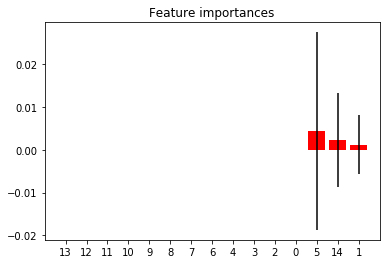

In [30]:
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

## Exploration of misclassified schools

We are interested in predicting schools that might be in danger of closing. This would be schools that are currently open, but that the model predicts are closed. (These would be the "false negative" cases.) There are 224 schools in this class that could be explored further.

In [31]:
result_dict = {'CURROPER':y_test, 'Predicted':AB_pred}
results = pd.DataFrame(result_dict)
results.head()

,CURROPER,Predicted
78206,True,True
51842,False,False
77105,True,True
72208,True,True
75211,True,False


In [32]:
predicted = pd.concat([X_test, results], axis=1)
predicted.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,DEBT_MDN,Cost,Complete,RetentionFT,CURROPER,Predicted
78206,4,0,3.0,8227.0,9878.5,2834.5,0.3333,0.6600,0.361719,0.303674,0.018592,6365.0,25081.0,0.3918,0.7273,True,True
51842,1,1,3.0,1839.0,9036.0,3386.0,0.9394,0.3622,0.500814,0.383550,0.000000,12100.0,30849.0,0.5029,0.6143,False,False
77105,9,3,3.0,515.0,21788.0,6529.0,0.2400,0.6233,0.458018,0.365530,0.022727,20181.0,22228.0,0.2629,0.8333,True,True
72208,5,3,2.0,533.0,9954.0,2570.0,0.9623,0.0576,0.284440,0.372646,0.021804,17000.0,35017.0,0.3354,0.6169,True,True
75211,1,2,3.0,211.0,13982.0,5275.0,0.6923,0.3679,0.519126,0.311475,0.000000,8751.0,12853.0,0.6224,0.6180,True,False


In [33]:
false_pos = predicted.loc[(predicted.Predicted == True) & (predicted.CURROPER == False)]
false_pos.shape

(312, 17)

In [34]:
false_neg = predicted.loc[(predicted.Predicted==False) & (predicted.CURROPER==True)]
false_neg.shape

(172, 17)

## Generate graphs for the report

In [35]:
predicted['Result'] = np.nan
predicted.loc[(predicted.Predicted==True)&(predicted.CURROPER==True), 'Result'] = 'TP'
predicted.loc[(predicted.Predicted==False)&(predicted.CURROPER==False), 'Result'] = 'TN'
predicted.loc[(predicted.Predicted==True)&(predicted.CURROPER==False), 'Result'] = 'FP'
predicted.loc[(predicted.Predicted==False)&(predicted.CURROPER==True), 'Result'] = 'FN'
print(predicted.Result)

78206    TP
51842    TN
77105    TP
72208    TP
75211    FN
         ..
73310    TP
77654    TP
75653    FN
58471    TN
76114    TP
Name: Result, Length: 3060, dtype: object


In [36]:
to_graph = pd.merge(predicted, data)
to_graph.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,...,ADM_RATE,AVGFACSAL,PCTFLOAN,Year,NetPrice,EnrollmentBins,TuitionBins,ExpenditureBins,FacultyBins,RetentionPT
0,4,0,3.0,8227.0,9878.5,2834.5,0.3333,0.6600,0.361719,0.303674,...,NaN,NaN,NaN,2013,21087.5,NaN,NaN,NaN,NaN,NaN
1,1,1,3.0,1839.0,9036.0,3386.0,0.9394,0.3622,0.500814,0.383550,...,NaN,3482.0,0.7147,2010,20136.0,large,high,med,low,NaN
2,9,3,3.0,515.0,21788.0,6529.0,0.2400,0.6233,0.458018,0.365530,...,0.5556,6559.0,0.8719,2013,19540.0,large,highest,high,high,0.0
3,5,3,2.0,533.0,9954.0,2570.0,0.9623,0.0576,0.284440,0.372646,...,0.9888,5650.0,0.7881,2013,17748.0,large,high,med,med,NaN
4,1,2,3.0,211.0,13982.0,5275.0,0.6923,0.3679,0.519126,0.311475,...,0.8291,2723.0,0.8000,2013,7441.0,medium,highest,med,low,NaN


In [37]:
to_graph.CONTROL = to_graph.CONTROL.astype('str')
to_graph.CONTROL.loc[to_graph.CONTROL == '1.0'] = 'Public'
to_graph.CONTROL.loc[to_graph.CONTROL == '2.0'] = 'NonProfit'
to_graph.CONTROL.loc[to_graph.CONTROL == '3.0'] = 'ForProfit'

to_graph.PREDDEG = to_graph.PREDDEG.astype('str')
#to_graph.drop(['EnrollmentBins', 'TuitionBins', 'ExpenditureBins', 'FacultyBins'], axis=1, inplace=True)
to_graph.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3430 entries, 0 to 3429
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NUMBRANCH          3430 non-null   int64  
 1   PREDDEG            3430 non-null   object 
 2   CONTROL            3430 non-null   object 
 3   UGDS               3430 non-null   float64
 4   TUITFTE            3430 non-null   float64
 5   INEXPFTE           3430 non-null   float64
 6   PFTFAC             3430 non-null   float64
 7   UG25abv            3430 non-null   float64
 8   COMP_ORIG_YR4_RT   3430 non-null   float64
 9   WDRAW_ORIG_YR4_RT  3430 non-null   float64
 10  ENRL_ORIG_YR4_RT   3430 non-null   float64
 11  DEBT_MDN           3430 non-null   float64
 12  Cost               3430 non-null   float64
 13  Complete           3430 non-null   float64
 14  RetentionFT        3430 non-null   float64
 15  CURROPER           3430 non-null   bool   
 16  Predicted          3430 

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [38]:
predControl = to_graph.pivot_table(index='PREDDEG', columns=['CONTROL','Result'], aggfunc='size')
print(predControl)

CONTROL ForProfit                      NonProfit                    Public  \
Result         FN     FP     TN     TP        FN    FP    TN     TP     FN   
PREDDEG                                                                      
0            19.0   16.0   71.0  388.0       3.0   6.0   3.0   45.0    1.0   
1           101.0  172.0  285.0  611.0      11.0  16.0  33.0   50.0    5.0   
2            21.0   29.0   57.0  159.0       NaN   4.0   7.0   49.0    NaN   
3             6.0   15.0   23.0   59.0       5.0  22.0  10.0  351.0    1.0   
4             1.0    1.0   19.0    8.0       2.0   6.0   8.0   73.0    NaN   

CONTROL                     
Result     FP    TN     TP  
PREDDEG                     
0         2.0   4.0   25.0  
1        16.0  20.0  170.0  
2         5.0   7.0  232.0  
3         1.0   2.0  169.0  
4         1.0   NaN    4.0  


In [39]:
false_neg = to_graph.loc[to_graph.Result == 'FN']
false_neg.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,...,ADM_RATE,AVGFACSAL,PCTFLOAN,Year,NetPrice,EnrollmentBins,TuitionBins,ExpenditureBins,FacultyBins,RetentionPT
4,1,2,ForProfit,211.0,13982.0,5275.0,0.6923,0.3679,0.519126,0.311475,...,0.8291,2723.0,0.8000,2013,7441.0,medium,highest,med,low,NaN
9,4,1,ForProfit,262.0,8428.0,4143.0,0.4545,0.6756,0.634694,0.192857,...,NaN,3737.0,0.9503,2013,19240.0,medium,high,med,low,NaN
34,1,1,ForProfit,39.0,1128.0,476.0,0.7222,0.6667,0.567568,0.153846,...,NaN,NaN,0.3492,2013,4597.0,small,low,low,NaN,0.5
35,1,1,ForProfit,121.0,5935.0,1715.0,1.0000,0.5041,0.466667,0.122222,...,NaN,NaN,0.2429,2013,14907.0,small,med,low,NaN,NaN
116,1,1,NonProfit,24.0,1854.0,6470.0,0.7500,0.2917,0.480461,0.000000,...,NaN,NaN,0.4783,2013,13528.5,small,low,high,NaN,NaN


## UGDS - Undergraduate enrollment

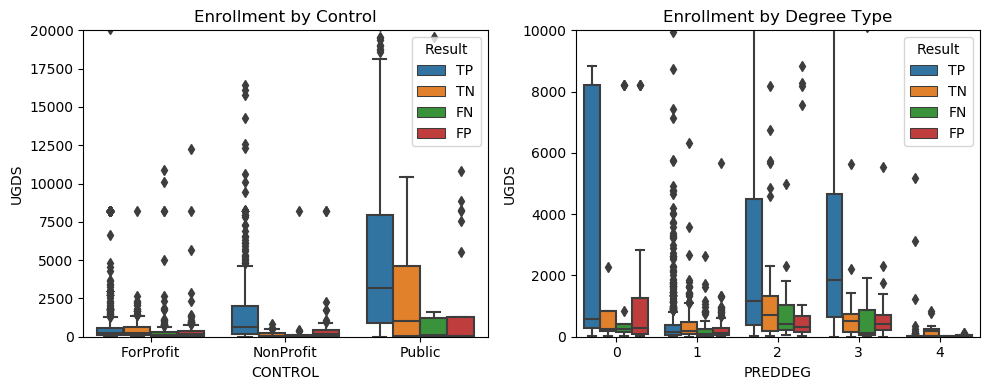

In [40]:
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.boxplot('CONTROL', 'UGDS', data = to_graph, hue = 'Result')
plt.ylim(0, 20000)
plt.title('Enrollment by Control')

plt.subplot(1, 2, 2)
sns.boxplot('PREDDEG', 'UGDS', data = to_graph, hue = 'Result')
plt.ylim(0, 10000)
plt.title('Enrollment by Degree Type')
plt.tight_layout()

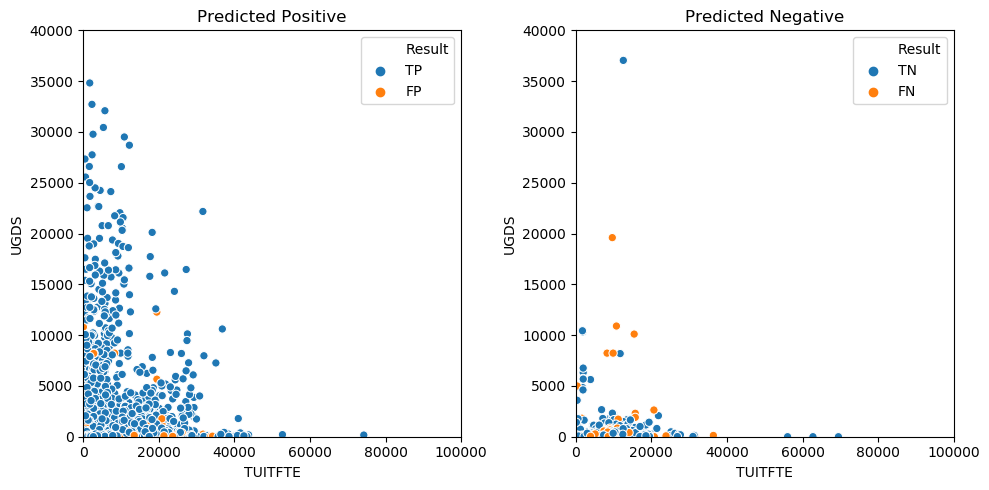

In [41]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==True], hue = 'Result')
plt.title('Predicted Positive')
plt.xlim(0,100000)
plt.ylim(0,40000)

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==False], hue = 'Result')
plt.title('Predicted Negative')
plt.xlim(0,100000)
plt.ylim(0,40000)
plt.tight_layout()
plt.show()

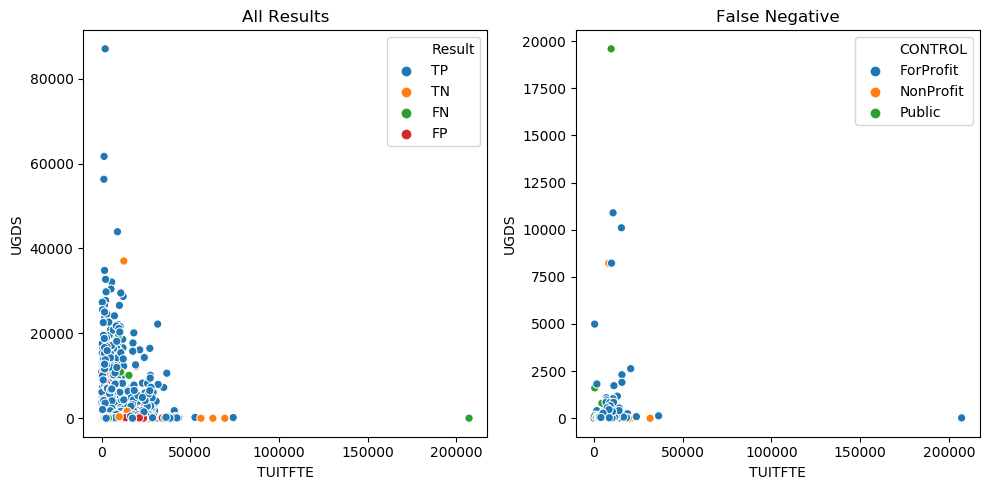

In [42]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph, hue = 'Result')
plt.title('All Results')
#plt.xlim(0,100000)
#plt.ylim(0,40000)

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Result=='FN'], hue = 'CONTROL')
plt.title('False Negative')
#plt.xlim(0,100000)
#plt.ylim(0,40000)
#plt.xlim(0,40000)
#plt.ylim(0,10000)
plt.tight_layout()
plt.show()

## Tuition and Cost

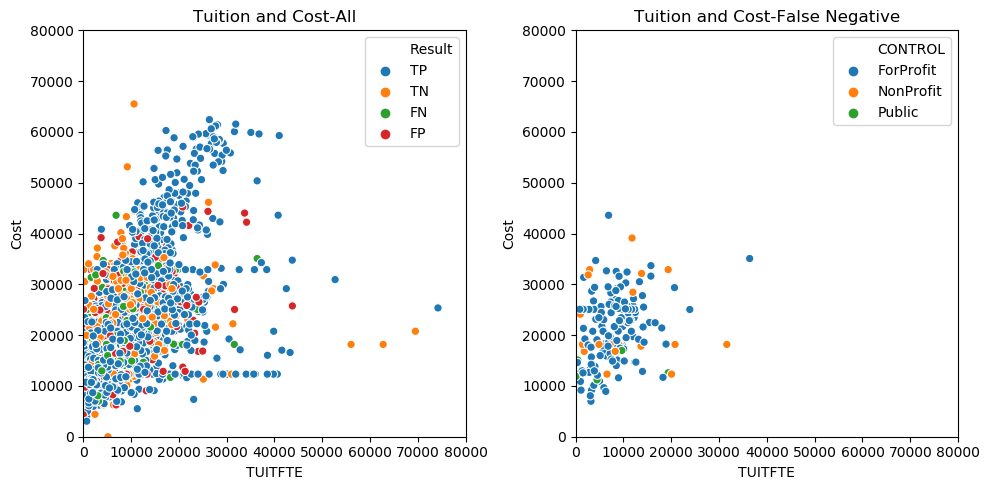

In [43]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'Cost', data=to_graph, hue = 'Result')
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Tuition and Cost-All')

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'Cost', data=to_graph.loc[to_graph.Result=='FN'], hue = 'CONTROL')
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Tuition and Cost-False Negative')
plt.tight_layout()
plt.show()

## Cost and Debt

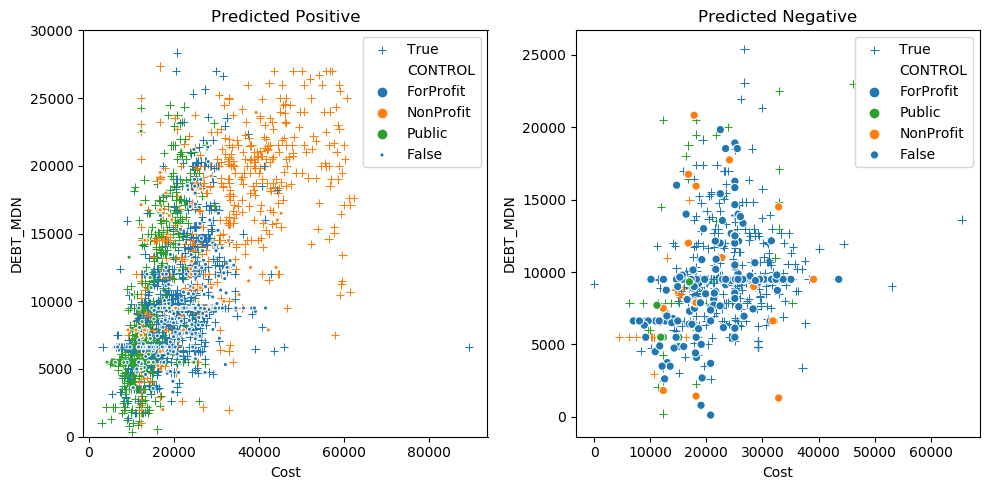

In [44]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
#sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Predicted==True], hue='CONTROL')
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='TP'], hue='CONTROL', marker='+', label='True')
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='FP'], hue='CONTROL', marker='.', label='False')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title('Predicted Positive')
plt.ylim(0,30000)

plt.subplot(1, 2, 2)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='TN'], hue='CONTROL', marker='+', label='True')
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='FN'], hue='CONTROL', marker='o', label='False')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title('Predicted Negative')
plt.tight_layout()
plt.show()

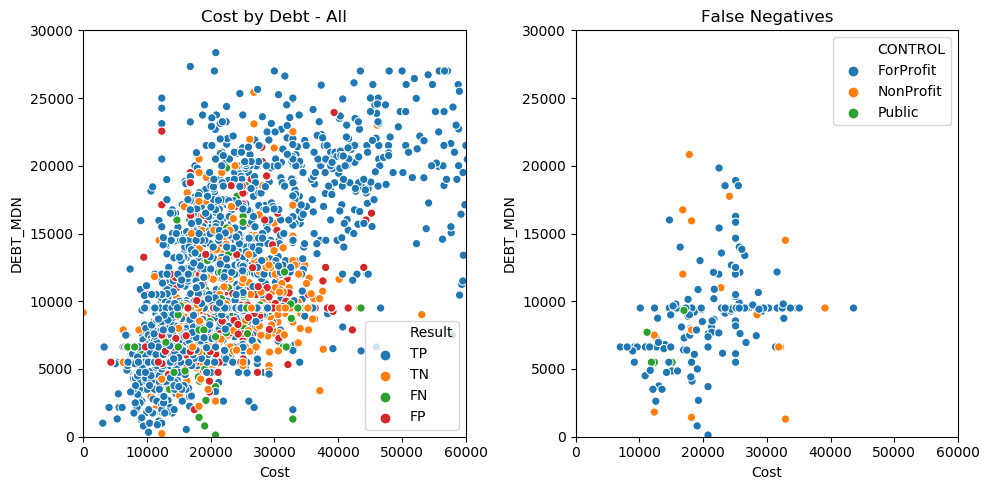

In [45]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph, hue='Result')
#sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='TP'], hue='CONTROL', marker='+', label='True')
#sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='FP'], hue='CONTROL', marker='.', label='False')
#handles, labels = plt.gca().get_legend_handles_labels()
#by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys())
plt.title('Cost by Debt - All')
plt.ylim(0,30000)
plt.xlim(0,60000)

plt.subplot(1, 2, 2)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='FN'], hue='CONTROL')
#sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='TN'], hue='CONTROL', marker='+', label='True')
#sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='FN'], hue='CONTROL', marker='o', label='False')
#handles, labels = plt.gca().get_legend_handles_labels()
#by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys())
plt.title('False Negatives')
plt.ylim(0,30000)
plt.xlim(0,60000)
plt.tight_layout()
plt.show()

## NumBranch

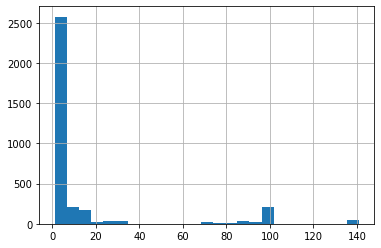

In [46]:
to_graph.NUMBRANCH.hist(bins=25)

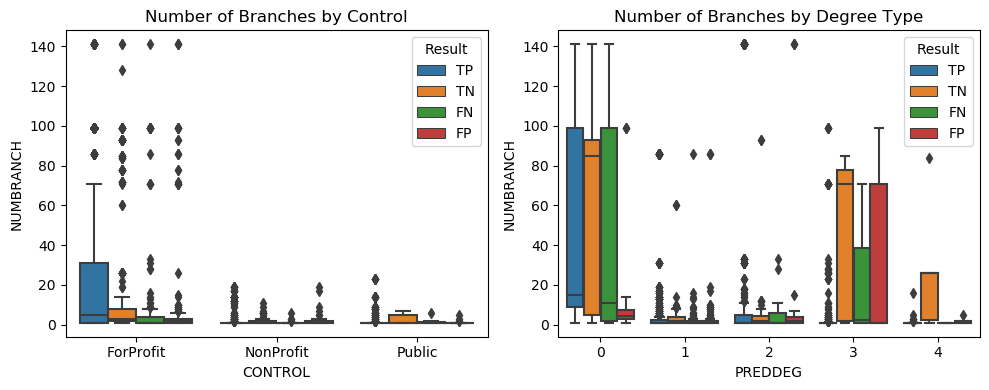

In [47]:
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.boxplot('CONTROL', 'NUMBRANCH', data = to_graph, hue = 'Result')
#plt.ylim(0, 100)
plt.title('Number of Branches by Control')

plt.subplot(1, 2, 2)
sns.boxplot('PREDDEG', 'NUMBRANCH', data = to_graph, hue = 'Result')
#plt.ylim(0, 100)
plt.title('Number of Branches by Degree Type')
plt.tight_layout()
plt.show()

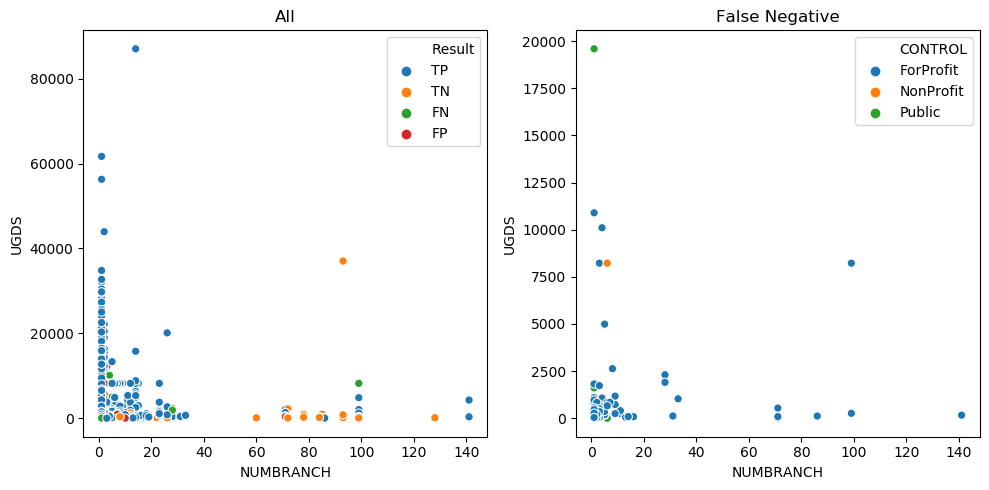

In [48]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('NUMBRANCH', 'UGDS', data=to_graph, hue = 'Result')
plt.title('All')

plt.subplot(1, 2, 2)
sns.scatterplot('NUMBRANCH', 'UGDS', data=to_graph.loc[to_graph.Result=='FN'], hue = 'CONTROL')
plt.title('False Negative')
plt.tight_layout()
plt.show()

## Instructional Expenditure

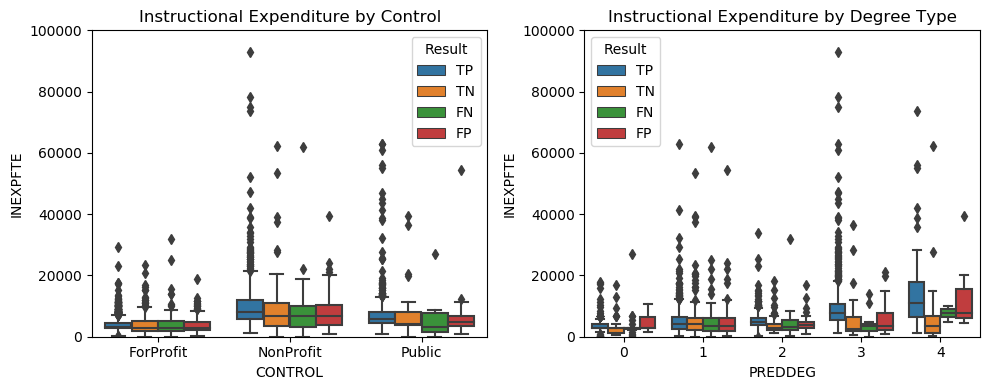

In [49]:
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.boxplot('CONTROL', 'INEXPFTE', data = to_graph, hue = 'Result')
plt.ylim(0, 100000)
plt.title('Instructional Expenditure by Control')

plt.subplot(1, 2, 2)
sns.boxplot('PREDDEG', 'INEXPFTE', data = to_graph, hue = 'Result')
plt.ylim(0, 100000)
plt.title('Instructional Expenditure by Degree Type')
plt.tight_layout()
plt.show()

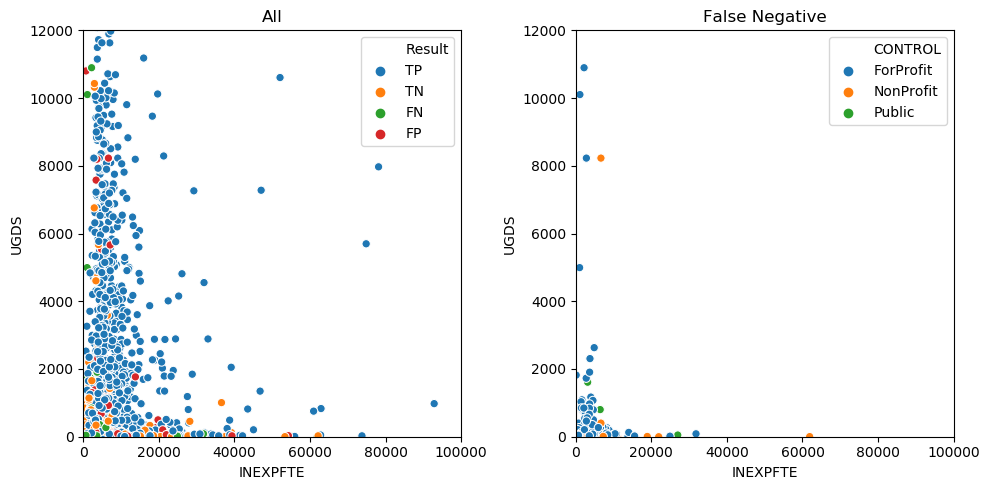

In [50]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('INEXPFTE', 'UGDS', data=to_graph, hue = 'Result')
plt.xlim(0, 100000)
plt.ylim(0, 12000)
plt.title('All')

plt.subplot(1, 2, 2)
sns.scatterplot('INEXPFTE', 'UGDS', data=to_graph.loc[to_graph.Result=='FN'], hue = 'CONTROL')
plt.xlim(0, 100000)
plt.ylim(0, 12000)
plt.title('False Negative')
plt.tight_layout()
plt.show()

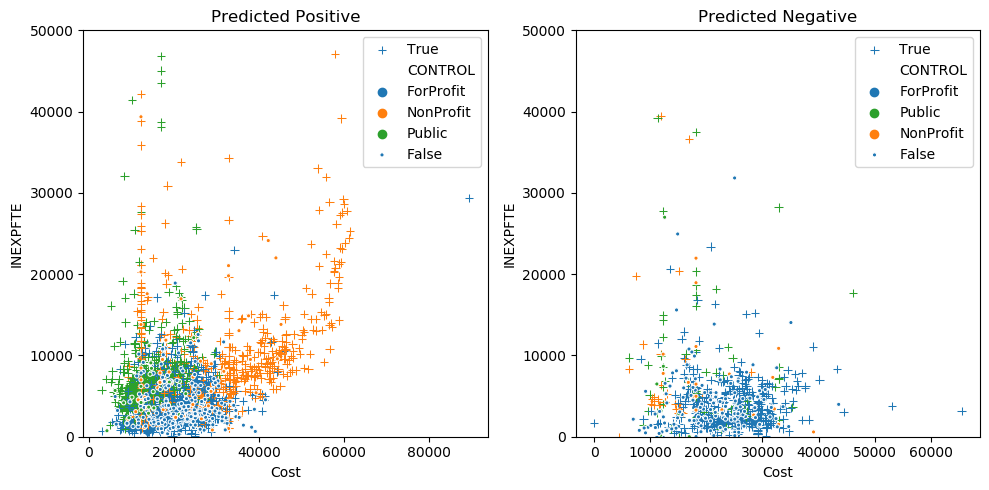

In [51]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
#sns.scatterplot('INEXPFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==True], hue = 'Result')
sns.scatterplot('Cost', 'INEXPFTE', data=to_graph.loc[to_graph.Result=='TP'], hue='CONTROL', marker='+', label='True')
sns.scatterplot('Cost', 'INEXPFTE', data=to_graph.loc[to_graph.Result=='FP'], hue='CONTROL', marker='.', label='False')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylim(0, 50000)
plt.title('Predicted Positive')

plt.subplot(1, 2, 2)
#sns.scatterplot('INEXPFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==False], hue = 'Result')
sns.scatterplot('Cost', 'INEXPFTE', data=to_graph.loc[to_graph.Result=='TN'], hue='CONTROL', marker='+', label='True')
sns.scatterplot('Cost', 'INEXPFTE', data=to_graph.loc[to_graph.Result=='FN'], hue='CONTROL', marker='.', label='False')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylim(0, 50000)
plt.title('Predicted Negative')
plt.tight_layout()
plt.show()